In [1]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version in torch:", torch.version.cuda)
print("Is torch built with CUDA:", torch.backends.cuda.is_built())


Torch version: 2.4.1+cpu
CUDA available: False
CUDA version in torch: None
Is torch built with CUDA: False


In [2]:
device = "cpu"

import numpy as np
import torch.nn as nn
import torch.nn.functional as F


In [3]:
import json

with open("../tokenizer_data/vocab.json", "r", encoding="utf-8") as f:
    vocab = json.load(f)

vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Vocabulary size: 2439


In [4]:
class DataLoader:
    def __init__(self, memmap_path: str, block_size: int, dtype = np.int32, start=0, end=None):
        self.tokens =  np.memmap(memmap_path, dtype=dtype, mode='r')
        self.block_size = block_size
        self.total_tokens = len(self.tokens)

        self.end = len(self.tokens) - block_size if end is None else end
        self.start = start
        self.length = self.end - self.start


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx += self.start
        if idx + self.block_size + 1 > self.end:
            raise IndexError("Index out of bounds.")
        block = self.tokens[idx : idx + self.block_size + 1]
        x = torch.tensor(block[:-1], dtype=torch.long)
        y = torch.tensor(block[1:], dtype=torch.long)
        return x, y

    def get_batch(self, batch_size: int, device='cpu'):
        idxs = np.random.randint(0, self.length, size=batch_size)
        x_list, y_list = zip(*[self[i] for i in idxs])
        x = torch.stack(x_list).to(device)
        y = torch.stack(y_list).to(device)
        return x, y

    @staticmethod
    def collate_fn(batch):
        x = torch.stack([item[0] for item in batch])
        y = torch.stack([item[1] for item in batch])
        return x, y

In [5]:
train_batch_size = 16  # training batch size
eval_batch_size = 8  # evaluation batch size
context_length = 256  # number of tokens processed in a single batch
block_size = 256
train_split = 0.9  # percentage of data to use from total data for training

In [6]:
flattened = np.memmap(
    "../tokenized_sql_dataset/flatten_token.memmap",
    dtype=np.int32,
    mode="r"
)

In [7]:
usable_tokens = len(flattened) - block_size
split_ratio = 0.9
split_index = int(usable_tokens * split_ratio)

In [8]:
memmap_path = "../tokenized_sql_dataset/flatten_token.memmap"

train_loader = DataLoader(
        memmap_path=memmap_path,
        block_size=block_size,
        dtype=np.int32,
        start=0,
        end=split_index
    )

eval_loader = DataLoader(
        memmap_path=memmap_path,
        block_size=block_size,
        dtype=np.int32,
        start=split_index,
        end=usable_tokens  # to avoid index errors
    )


In [10]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, context_length, d_model) -> None:
        super().__init__()
        # Create a matrix of shape (context_length, d_model) to store the positional encodings
        pe = torch.zeros(context_length, d_model)
        
        # Create a vector with positions [0, 1, 2, ..., context_length-1] of shape (context_length, 1)
        position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
        
        # Create a vector with the divisor terms based on the dimension
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Shape: (1, context_length, d_model)
        
        # Register pe as a buffer, so it is not considered a parameter but is part of the module's state
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Add the positional encodings to the input embeddings
        return x + self.pe[:,:x.size(1), :] 


In [13]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, d_model) # word token embeddings
        self.lm_head = nn.Linear(d_model, vocab_size)
        self.wpe = PositionalEncoding(context_length, d_model)

    
    def forward(self, inputs, targets=None):
        x = self.wte(inputs)                                   # [B, T, d_model]
        logits = self.lm_head(x)                               # [B, T, vocab_size]

        loss = None
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B * T, V)                     # flatten for CE
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, inputs, max_new_tokens):
        # this will store the model outputs along with the initial input sequence
        # make a copy so that it doesn't interfare with model
        for _ in range(max_new_tokens):
            # we only pass targets on training to calculate loss
            logits, _ = self(inputs)
            # for all the batches, get the embeds for last predicted sequence
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            # get the probable token based on the input probs
            idx_next = torch.multinomial(probs, num_samples=1)

            inputs = torch.cat([inputs, idx_next], dim=1)
        # as the inputs has all model outputs + initial inputs, we can use it as final output
        return inputs

In [12]:
basic_model = GPT(vocab_size=2439, d_model=256).to(device)
lr = 1e-3
optimizer = torch.optim.AdamW(basic_model.parameters(), lr=lr)

In [16]:
from tqdm import trange, tqdm

epochs = 1000
eval_steps = 50  # perform evaluation every n steps

train_loss = {}

for ep in trange(epochs, desc="Training Epochs"):
    xb, yb = train_loader.get_batch(train_batch_size, device)

    logits, loss = basic_model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    train_loss[ep] = loss.item()

    if ep % eval_steps == 0 or ep == epochs - 1:
        basic_model.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch(eval_batch_size, device)
            _, e_loss = basic_model(xvb, yvb)

            tqdm.write(f"Epoch: {ep}\ttrain_loss: {loss.item():.4f}\teval_loss: {e_loss.item():.4f}")
        basic_model.train()  # back to training mode


Training Epochs:   0%|          | 3/1000 [00:00<01:33, 10.66it/s]

Epoch: 0	train_loss: 3.4258	eval_loss: 4.2021


Training Epochs:   5%|▌         | 53/1000 [00:04<01:24, 11.25it/s]

Epoch: 50	train_loss: 3.0856	eval_loss: 3.8095


Training Epochs:  10%|█         | 103/1000 [00:09<01:22, 10.84it/s]

Epoch: 100	train_loss: 3.0169	eval_loss: 3.7549


Training Epochs:  15%|█▌        | 153/1000 [00:13<01:19, 10.62it/s]

Epoch: 150	train_loss: 2.8286	eval_loss: 3.4647


Training Epochs:  20%|██        | 201/1000 [00:18<01:15, 10.53it/s]

Epoch: 200	train_loss: 3.1218	eval_loss: 3.5570


Training Epochs:  25%|██▌       | 251/1000 [00:23<01:12, 10.31it/s]

Epoch: 250	train_loss: 2.8983	eval_loss: 3.4029


Training Epochs:  30%|███       | 303/1000 [00:28<01:06, 10.49it/s]

Epoch: 300	train_loss: 2.7564	eval_loss: 3.5716


Training Epochs:  35%|███▌      | 352/1000 [00:32<01:02, 10.38it/s]

Epoch: 350	train_loss: 2.9953	eval_loss: 3.3023


Training Epochs:  40%|████      | 402/1000 [00:37<00:58, 10.14it/s]

Epoch: 400	train_loss: 2.9783	eval_loss: 3.3696


Training Epochs:  45%|████▌     | 453/1000 [00:42<00:53, 10.30it/s]

Epoch: 450	train_loss: 3.0801	eval_loss: 3.2468


Training Epochs:  50%|█████     | 503/1000 [00:47<00:47, 10.49it/s]

Epoch: 500	train_loss: 2.9212	eval_loss: 3.2913


Training Epochs:  55%|█████▌    | 553/1000 [00:52<00:42, 10.48it/s]

Epoch: 550	train_loss: 2.9188	eval_loss: 3.4442


Training Epochs:  60%|██████    | 603/1000 [00:56<00:38, 10.31it/s]

Epoch: 600	train_loss: 3.1184	eval_loss: 3.3871


Training Epochs:  65%|██████▌   | 651/1000 [01:01<00:44,  7.91it/s]

Epoch: 650	train_loss: 2.9913	eval_loss: 3.3904


Training Epochs:  70%|███████   | 703/1000 [01:06<00:28, 10.46it/s]

Epoch: 700	train_loss: 2.8560	eval_loss: 3.3437


Training Epochs:  75%|███████▌  | 753/1000 [01:10<00:20, 12.00it/s]

Epoch: 750	train_loss: 2.9576	eval_loss: 3.4557


Training Epochs:  80%|████████  | 803/1000 [01:15<00:16, 11.87it/s]

Epoch: 800	train_loss: 2.9912	eval_loss: 3.6295


Training Epochs:  85%|████████▌ | 853/1000 [01:19<00:12, 12.00it/s]

Epoch: 850	train_loss: 2.8431	eval_loss: 3.5201


Training Epochs:  90%|█████████ | 903/1000 [01:23<00:08, 11.90it/s]

Epoch: 900	train_loss: 2.8694	eval_loss: 3.2068


Training Epochs:  95%|█████████▌| 953/1000 [01:27<00:04, 11.71it/s]

Epoch: 950	train_loss: 2.8542	eval_loss: 3.3563


Training Epochs: 100%|██████████| 1000/1000 [01:31<00:00, 10.92it/s]

Epoch: 999	train_loss: 2.8780	eval_loss: 3.2601


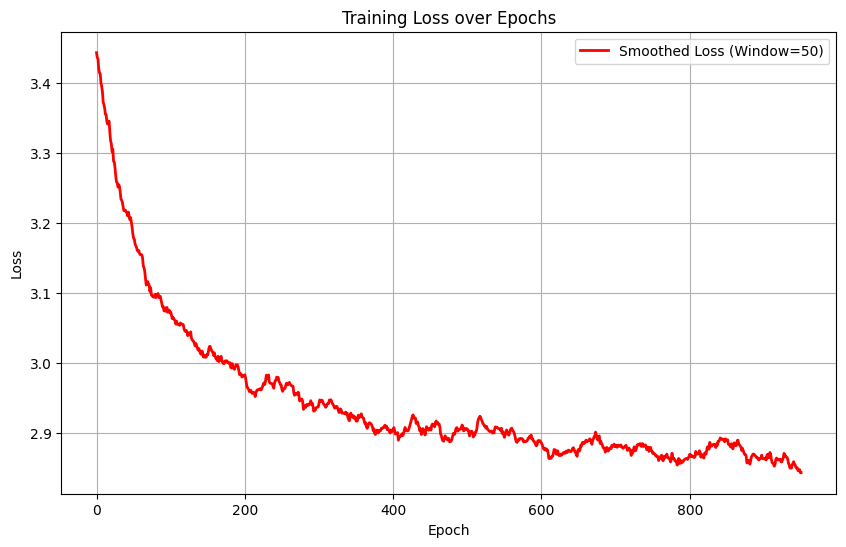

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loss is your dictionary with epoch and loss
epochs = list(train_loss.keys())
losses = list(train_loss.values())

# Smoothing parameters
smooth_window = 50  # Adjust the window size for smoothing

# Smoothed losses using moving average
smoothed_losses = np.convolve(losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
from bpe.fast_token import FastBPETokenizer
tokenizer = FastBPETokenizer()

tokenizer.load("../tokenizer_data")
tokens = tokenizer.tokenize_to_ids("find")

In [31]:
text = ''''Which tests have 'Pass' results? Return the dates when the tests were taken, and count them by a line chart, and I want to display by the X-axis in asc.
CREATE TABLE Courses (course_id INTEGER,author_id INTEGER,subject_id INTEGER,course_name VARCHAR(120),course_description VARCHAR(255))
CREATE TABLE Student_Course_Enrolment (registration_id INTEGER,student_id INTEGER,course_id INTEGER,date_of_enrolment DATETIME,date_of_completion DATETIME)CREATE TABLE Student_Tests_Taken (registration_id INTEGER,date_test_taken DATETIME,test_result VARCHAR(255))CREATE TABLE Students (student_id INTEGER,date_of_registration DATETIME,date_of_latest_logon DATETIME,login_name VARCHAR(40),password VARCHAR(10),personal_name VARCHAR(40),middle_name VARCHAR(40),family_name VARCHAR(40))CREATE TABLE Subjects (subject_id INTEGER,subject_name VARCHAR(120))CREATE TABLE Course_Authors_and_Tutors (author_id INTEGER,author_tutor_ATB VARCHAR(3),login_name VARCHAR(40),password VARCHAR(40),personal_name VARCHAR(80),middle_name VARCHAR(80),family_name VARCHAR(80),gender_mf VARCHAR(1),address_line_1 VARCHAR(80))
=>
'''


input_tokens = torch.tensor(tokenizer.tokenize_to_ids(text), dtype=torch.long)

In [32]:
basic_model.eval()

with torch.no_grad():
    logits, _ = basic_model(input_tokens)
    predicted_ids = torch.argmax(logits, dim=-1)  # pick the most likely token at each position

print("Predicted token IDs:", predicted_ids)


Predicted token IDs: tensor([ 81,  15,  58,  96, 132, 259, 198, 118,   9, 121,  15, 208, 189, 149,
         15,   9, 116, 120,  94,  94, 149,  36,   9,  67,  89,  94, 103,  53,
        254,  89,  89,   9, 112, 120, 254, 198, 118,   9,  90, 264,  94, 136,
        132,   7,  93, 211, 255, 207,  99, 259, 264,   9,  94, 244, 267,  15,
         94,   7,  93, 283,  90, 126, 207, 258,  89, 251, 118, 280, 264, 254,
         73,  21, 252,  36, 264, 264, 189, 211,  52,  76, 254,  73, 249, 149,
          9,  61, 211, 249, 200, 207,  66,  73,  36,  70,  54,  70,  67,   7,
        252, 252, 104, 254, 207,  66,  73,  36,  70,  54,  70,  67,   7, 120,
        188, 140, 254,  94, 207,  66,  73,  36,  70,  54,  70,  67,   7, 211,
        249, 200, 125, 102, 259,  45,  70,  67,  73,  45,  70,  67,  61,  36,
         23,  15,   7, 211, 249, 200, 125,  89, 125, 211, 230, 115, 258,  45,
         70,  67,  73,  45,  70,  67,  61,  27,  10,  10,  15,  41,  76, 254,
         54,  94, 252,  89, 247, 125,  73, 

In [33]:
predicted_ids = predicted_ids.tolist()
decode = tokenizer.decode_from_ids(predicted_ids)
print("Decoded output:", decode)

Decoded output: W,Haddtext,may(be,oker,(ationbababer (O_abanDt__(at btmay(_id the abed'a odt number,altext,the (abstime,ab'a w_id ce number,text_siayvthe tT0st the the kodCREATE TABLE tTseer(Id odsemenumber,NT RERO'ststan tnumber,NT RERO'bjectabnumber,NT RERO'odsemecame text,AROTAROId  2,'odsemec_codpatitextAROTAROId 5)),=TABLE tEabst_s cTsemecRame wab_id (Id ationeteayuDnumber,NT RERO'ayst_s number,NT RERO'odsemenumber,NT RERO'__cstlcdwab_id ( ER N R'__cstlcpati_text ER N RTABLE tEabst_s c _ayerc ebId ationeteayuDnumber,NT RERO'__cmaycabeb ER N R'maycationbabnumber,AROTAROId 5)),TABLE tEabst_s (Id ayst_s number,NT RERO'__cstlcationeteayutext, ER N R'__cstlcab_aycabstetext, ER N R'abstescame text,AROTAROId  0,'atiker_id tnumber,AROTAROId  0,'ierg_came text,AROTAROId  0,'_id an__came text,AROTAROId  0,'les pcame text,AROTAROId  0,TABLE tEstject(Id bjectabnumber,NT RERO'bjectabcame text,AROTAROId  2,TABLE tTsemecRstan tercce _c stabt(Id ststan tnumber,NT RERO'ststan tcabstabtcEY(AROTAROI

In [34]:
input_tokens = input_tokens.unsqueeze(0).to(device)

In [36]:
with torch.no_grad():
    generated = basic_model.generate(input_tokens, max_new_tokens=200)

generated_ids = generated[0].tolist()
decode = tokenizer.decode_from_ids(generated_ids)
print("Decoded output:", decode)

Decoded output: <bos>'Which tests have 'Pass' results? Return the dates when the tests were taken, and count them by a line chart, and I want to display by the X-axis in asc. CREATE TABLE Courses (course_id INTEGER,author_id INTEGER,subject_id INTEGER,course_name VARCHAR(120),course_description VARCHAR(255)) CREATE TABLE Student_Course_Enrolment (registration_id INTEGER,student_id INTEGER,course_id INTEGER,date_of_enrolment DATETIME,date_of_completion DATETIME)CREATE TABLE Student_Tests_Taken (registration_id INTEGER,date_test_taken DATETIME,test_result VARCHAR(255))CREATE TABLE Students (student_id INTEGER,date_of_registration DATETIME,date_of_latest_logon DATETIME,login_name VARCHAR(40),password VARCHAR(10),personal_name VARCHAR(40),middle_name VARCHAR(40),family_name VARCHAR(40))CREATE TABLE Subjects (subject_id INTEGER,subject_name VARCHAR(120))CREATE TABLE Course_Authors_and_Tutors (author_id INTEGER,author_tutor_ATB VARCHAR(3),login_name VARCHAR(40),password VARCHAR(40),personal_